### Import Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

### Download and Load Dataset

In [26]:
heart = fetch_ucirepo(id=45)
X = heart.data.features
y = pd.Series((heart.data.targets.values.ravel() > 0).astype(int), name="target")
df = pd.concat([X, y], axis=1)

In [27]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [28]:
print("Shape:", df.shape)
print("Missing values per column:\n", df.isna().sum())

Shape: (303, 14)
Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


### Data Exploration

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int32  
dtypes: float64(3), int32(1), int64(10)
memory usage: 32.1 KB


In [30]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


### Data Cleaning

In [31]:
# 3) Data Cleaning: impute missing numeric values (ca, thal)
imputer = SimpleImputer(strategy='median')
df[df.columns] = imputer.fit_transform(df)
print("\nAfter imputation, missing per column:\n", df.isna().sum())


After imputation, missing per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


### EDA: Class balance and correlations

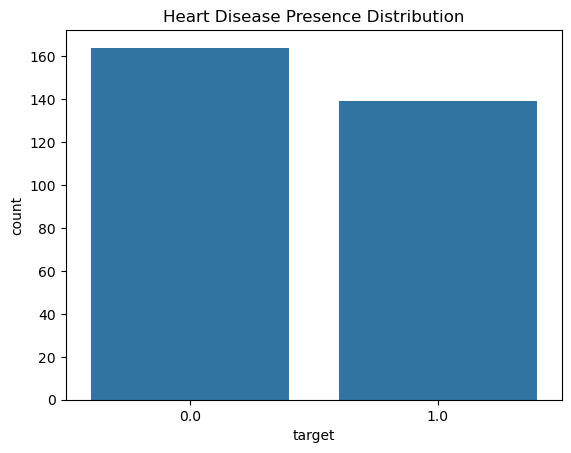

In [32]:
sns.countplot(x='target', data=df)
plt.title("Heart Disease Presence Distribution")
plt.show()

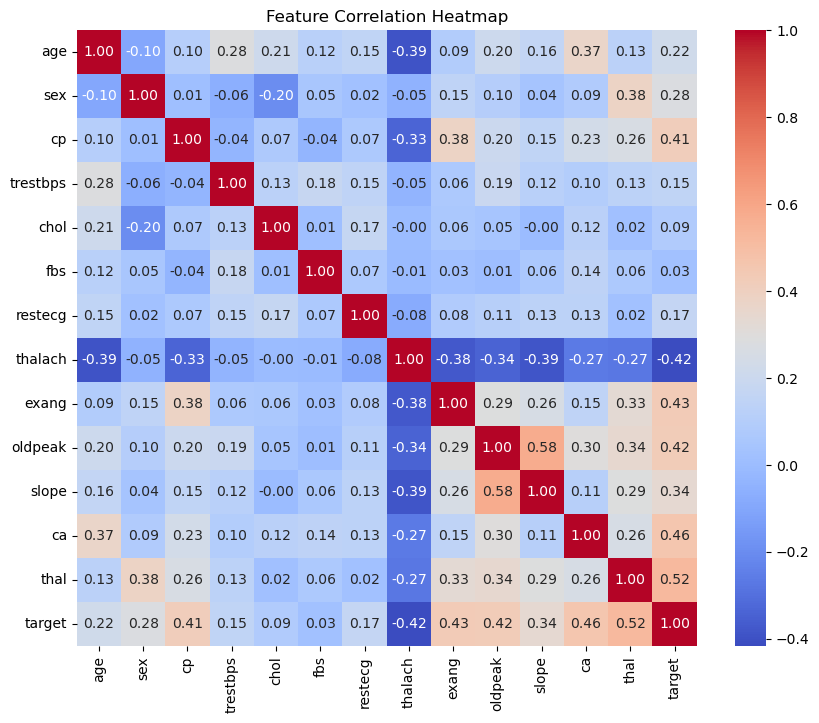

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

### Scaling
1. Separates the features (X) and the target variable (y) 
2. Standardizes the features using normalization



In [34]:
X = df.drop('target', axis=1)
y = df['target']
X_scaled = StandardScaler().fit_transform(X)

### Splitting

1. Splits your standardized data into training and test sets (80/20)
2. Keeps the same class distribution using stratify=y
3. Ensures reproducibility with random_state=42



In [35]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Model: Single Layer Perceptron

This is a simple baseline model (no hidden layers, just input → output)

In [36]:
# Base model
base_model = MLPClassifier(hidden_layer_sizes=(), activation='logistic', 
                           max_iter=1000, random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

### Hyperparameter Tuning

This code performs hyperparameter tuning for your base model using Grid Search with Cross-Validation

In [37]:
# Grid Search for hyperparameter tuning
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}
grid = GridSearchCV(base_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'alpha': 0.0001, 'learning_rate_init': 0.001}


### Selecting Best Model from Grid Search

This code takes the best model found during grid search and uses it to make predictions on the test data.

In [38]:
# Best model from grid search
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

### Comparing base model vs best model

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def print_metrics(name, y_true, y_pred, model):
    print(f"--- {name} ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_true, model.predict_proba(X_test)[:,1]):.4f}")
    print()

In [40]:
print_metrics("Base Model", y_test, y_pred_base, base_model)
print_metrics("Best Model", y_test, y_pred_best, best_model)

--- Base Model ---
Accuracy:  0.8689
Precision: 0.8125
Recall:    0.9286
F1 Score:  0.8667
ROC AUC:   0.9524

--- Best Model ---
Accuracy:  0.8689
Precision: 0.8125
Recall:    0.9286
F1 Score:  0.8667
ROC AUC:   0.9524



### Inference: Base model itself is the best model

### Model: Decision Tree Classifier

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
# base model
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)
y_pred_dt_base = dt_base.predict(X_test)


In [43]:
dt_param_grid = {
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, 
                       cv=5, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [44]:
# Best Decision Tree model from grid search
dt_best = dt_grid.best_estimator_
y_pred_dt_best = dt_best.predict(X_test)
print("Best Decision Tree params:", dt_grid.best_params_)


Best Decision Tree params: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [45]:
print_metrics("Decision Tree Base", y_test, y_pred_dt_base, dt_base)
print_metrics("Decision Tree Best", y_test, y_pred_dt_best, dt_best)

--- Decision Tree Base ---
Accuracy:  0.7213
Precision: 0.6571
Recall:    0.8214
F1 Score:  0.7302
ROC AUC:   0.7289

--- Decision Tree Best ---
Accuracy:  0.7869
Precision: 0.7419
Recall:    0.8214
F1 Score:  0.7797
ROC AUC:   0.8728



### Visualizations: Comparison between models

#### Confusion Matrix

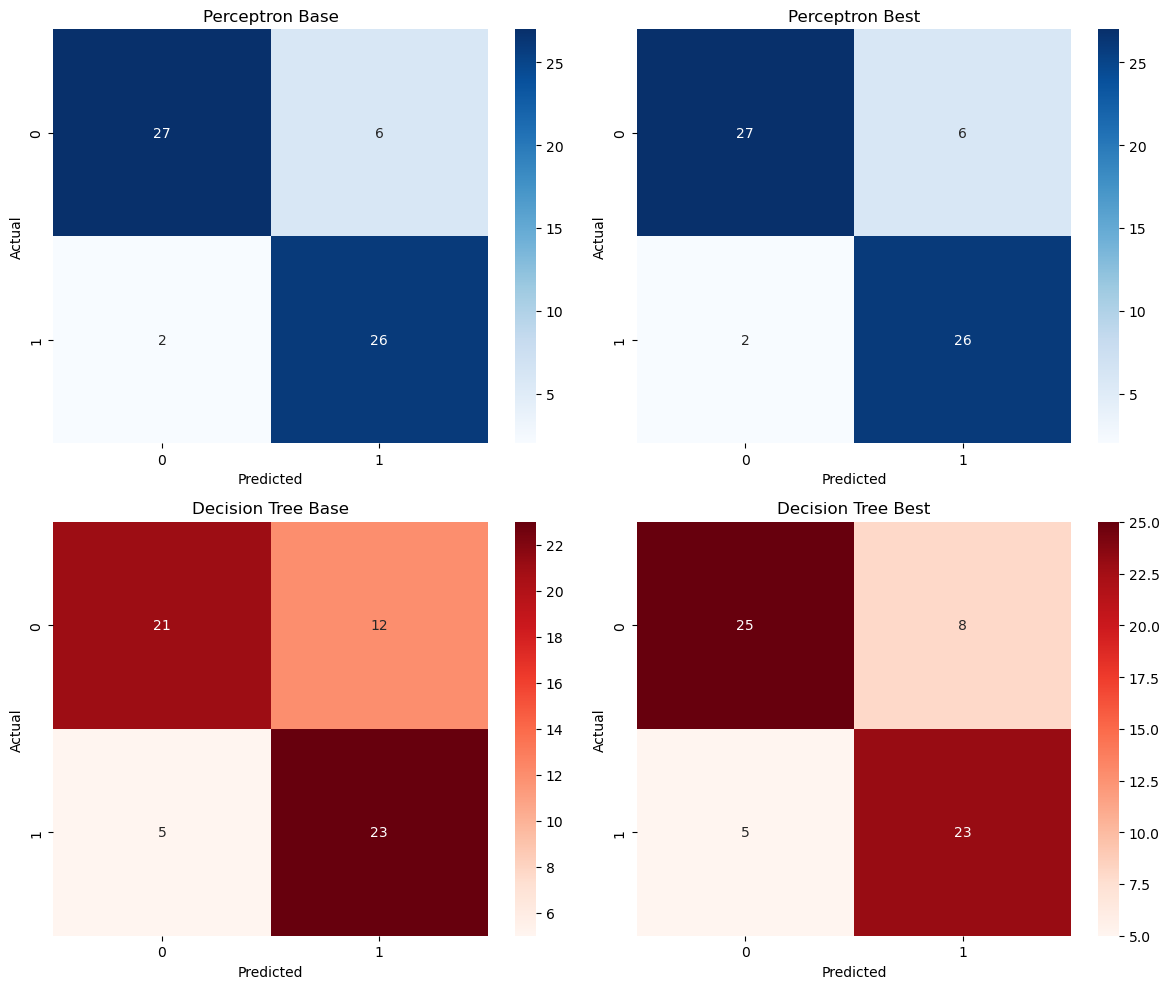

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='d', cmap='Blues', ax=axs[0,0])
axs[0,0].set_title("Perceptron Base")
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', ax=axs[0,1])
axs[0,1].set_title("Perceptron Best")

sns.heatmap(confusion_matrix(y_test, y_pred_dt_base), annot=True, fmt='d', cmap='Reds', ax=axs[1,0])
axs[1,0].set_title("Decision Tree Base")
sns.heatmap(confusion_matrix(y_test, y_pred_dt_best), annot=True, fmt='d', cmap='Reds', ax=axs[1,1])
axs[1,1].set_title("Decision Tree Best")

for ax in axs.flat:
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

#### ROC curves

<Figure size 800x600 with 0 Axes>

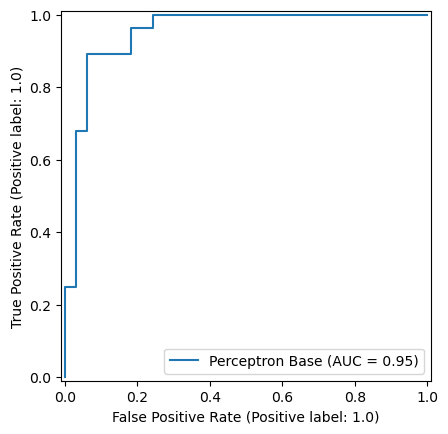

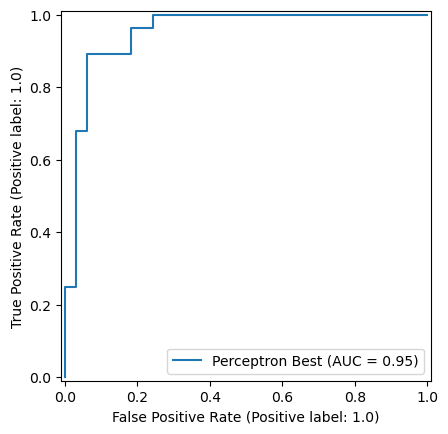

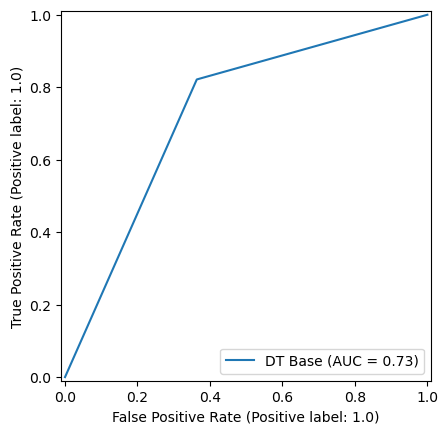

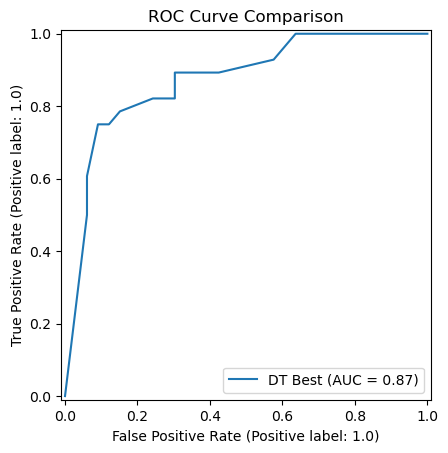

In [47]:
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(base_model, X_test, y_test, name='Perceptron Base')
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name='Perceptron Best')
RocCurveDisplay.from_estimator(dt_base, X_test, y_test, name='DT Base')
RocCurveDisplay.from_estimator(dt_best, X_test, y_test, name='DT Best')
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()